# xAI Wake Classifier

### Download data:

In [ ]:
import requests
from tqdm import tqdm

def download_file(url, filename):
    """
    Download a file from the specified URL and save it locally.
    """
    # Send a GET request to the URL
    response = requests.get(url, stream=True)

    # Total size in bytes
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    with open(filename, 'wb') as file, tqdm(
        total=total_size, unit='iB', unit_scale=True
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

# URL of the file to be downloaded
url = "https://zenodo.org/records/10018939/files/xAIWakes.zip?download=1"

# Local filename to save the downloaded file
filename = "xAIWakes.zip"

# Download the file
download_file(url, filename)

print(f"Downloaded '{filename}'.")


### Extract data:

In [ ]:
import zipfile

# Specify the path to the zip file and the extraction directory
zip_path = 'xAIWakes.zip'
extract_to = 'xAIWakes'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## Data Preprocessing

1. Turned every image into png.
2. Downsampled every image into 256x256 with black padding.
3. Stacked all the bands into the same file. Final images have the following dimensions ([4, 256, 256]).
4. Put every image inside a single folder
5. Created a .csv file with the names of the images and their label (0=no_wake, 1=wake).

## Imports

In [ ]:
from typing import Any

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.types import STEP_OUTPUT
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

import torchvision
import torchvision.transforms
import torchvision.transforms as transforms
from torchvision.transforms import v2

import torchmetrics
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix

import numpy
import numpy as np
from numpy import logspace

from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import datetime # Used only to name savefig of confusion matrix
import pandas as pd
import os
from skimage import io


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Config

Change DATA_DIR to the image folder, and CSV_DIR to the csv file with the filenames and target labels. 

In [ ]:
import torchvision.transforms
from torchvision.transforms import v2
from numpy import logspace

# Random seed
SEED = 41

# Training hyperparameters
IN_CHANNELS = 4
NUM_CLASSES = 2
LEARNING_RATE = 0.0019 # GWO su dataset (solo acc): 1e-1 || GWO su augmented dataset (acc 3, f1 2): 0.0925
BATCH_SIZE = 23 # GWO su dataset (solo acc): 24 || GWO su augmented dataset (acc 3, f1 2): 42
NUM_EPOCHS = 20

# Dataset
DATA_DIR = rf'C:\Users\andre\PycharmProjects\WakeClassification\xAIWakes_resized\Combined'
CSV_DIR = rf'C:\Users\andre\PycharmProjects\WakeClassification\xAIWakes_resized\xAIWakes_dataset.csv'

# Augmented dataset
#DATA_DIR = rf'C:\Users\andre\PycharmProjects\WakeClassification\xAIWakes_resized\Combined_augmented'
#CSV_DIR = rf'C:\Users\andre\PycharmProjects\WakeClassification\xAIWakes_resized\xAIWakes_dataset_augmented.csv'

NUM_WORKERS = 0 # 4
TRANSFORM = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])
TRANSFORM_SIMPLE = torchvision.transforms.ToTensor()

# Compute related
ACCELERATOR = "gpu"
DEVICES = [0]
#PRECISION = 16

# Logs
LOGS_DIR = rf"C:\Users\andre\PycharmProjects\WakeClassification\tb_logs"
CONF_MATRIX_DIR = rf"C:\Users\andre\PycharmProjects\WakeClassification\tb_logs"
LOGS_DIR_GWO = rf"C:\Users\andre\PycharmProjects\WakeClassification\tb_logs\GWO_logs" # GWO plots

## For Hyperparameter search using tensorboard (https://www.youtube.com/watch?v=RLqsxWaQdHE&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=15)
#BATCH_SIZES = [4, 8, 16]
#LEARNING_RATES = logspace(-4, -1, 5)
#LOGS_DIR_HPS = rf"C:\Users\andre\PycharmProjects\WakeClassification\tb_logs_hps"

## Dataset

In [ ]:
class xAIWakesDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        super().__init__()
        self.annotations = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations) # XAI has 269 images

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)


class xAIWakesDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, root_dir, batch_size, num_workers, transform=None):
        super().__init__()
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def prepare_data(self):
        # Left empty as data is already downloaded and preprocessed
        pass

    def setup(self, stage):
        my_ds = xAIWakesDataset(self.csv_file, self.root_dir, self.transform)
        self.train_ds, self.val_ds, self.test_ds = random_split(my_ds, [0.6, 0.1, 0.3])
        # my_predict_ds = xAIWakesDataset(rf"C:\\path_to_csv", root_dir)
        # self.predict_ds = my_predict_ds
        self.predict_ds = my_ds

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            #persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            #persistent_workers=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            #persistent_workers=True,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            #persistent_workers=True,
        )

## Model

Change the predict_step and on_predict_end depending on the desired output of the inference.
Also, change save directory for the on_predict_end.

In [ ]:
class WakeClassifier(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False) # bias=False because bn is applied
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # Dropout
        self.drop = nn.Dropout(p=0.4)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with 2 classes

        # Other
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = BinaryAccuracy()
        self.test_accuracy = 0.0 # for hyperparameter optimization
        self.f1_score = BinaryF1Score()
        self.conf_matrix = BinaryConfusionMatrix()
        self.conf_matrix_pred = BinaryConfusionMatrix()
        
    def forward(self, x):
        # Convolutional layers with ReLU activation, batch normalization, and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop(self.fc2(x))
        return x

In [ ]:
class WakeClassifierPlModule(pl.LightningModule):
    def __init__(self, in_channels=4, num_classes=2, learning_rate=1e-3):
        super(WakeClassifier, self).__init__()
        self.lr = learning_rate
        self.model = WakeClassifier(num_classes=2)

    def forward(self, x):
        # Convolutional layers with ReLU activation, batch normalization, and max pooling
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(torch.argmax(scores, dim=1), y)
        f1_score = self.f1_score(torch.argmax(scores, dim=1), y)
        self.log_dict({
            'train_loss': loss, 
            'train_accuracy': accuracy,
            'train_f1_score': f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
            )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        self.accuracy.update(torch.argmax(scores, dim=1), y)
        self.f1_score.update(torch.argmax(scores, dim=1), y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(torch.argmax(scores, dim=1), y)
        f1_score = self.f1_score(torch.argmax(scores, dim=1), y)
        self.conf_matrix.update(torch.argmax(scores, dim=1), y)
        self.conf_matrix.compute()
        self.log_dict({
            'test_loss': loss, 
            'test_accuracy': accuracy,
            'test_f1_score': f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
            )
        return loss

    def on_test_end(self):
        fig_, ax_ = self.conf_matrix.plot()  # to plot and save confusion matrix
        plt.xlabel('Prediction')
        plt.ylabel('Class')
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plt.savefig(rf".\tb_logs\confusion_matrix_{current_datetime}.png")
        #plt.show()


    def _common_step(self, batch, batch_idx):
        x, y = batch
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        return loss, scores, y
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        accuracy = self.accuracy(preds, y)
        f1_score = self.f1_score(preds, y)
        self.conf_matrix_pred.update(preds, y)
        self.conf_matrix_pred.compute()

        print(f" - Accuracy: {accuracy:.3f}, F1-score: {f1_score:.3f}")
        return preds

    def on_predict_end(self):
        fig_, ax_ = self.conf_matrix_pred.plot()
        plt.xlabel('Prediction')
        plt.ylabel('Class')
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plt.savefig(rf"C:\Users\andre\PycharmProjects\WakeClassification\tb_logs\confusion_matrix_predictions_{current_datetime}.png")
        plt.show()  # test block=False

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    

## Basic check
#model = WakeClassifier()
#x = torch.randn(4, 4, 256, 256)
#print(model(x).shape)
#exit()

## Train

Note: workers are set to 0 and are set to not be persistent in the dataloaders because of some issue with notebook. Refer to this (https://github.com/pytorch/pytorch/issues/5301)

In [ ]:
seed = pl.seed_everything(seed=SEED, workers=True) # For reproducibility
torch.set_float32_matmul_precision("medium") # to make lightning happy

In [ ]:
logger = TensorBoardLogger(save_dir=LOGS_DIR, name=f"wakeclassifier_model_dropout_v0_lr{LEARNING_RATE}_bs{BATCH_SIZE}")
#profiler = PyTorchProfiler(
#    on_trace_ready=torch.profiler.tensorboard_trace_handler("tb_logs/profiler0"),
#    schedule=torch.profiler.schedule(skip_first=5, wait=1, warmup=1, active=20),
#)
model = WakeClassifier(
    in_channels=IN_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE
)
dm = xAIWakesDataModule( # self, csv_file, root_dir, batch_size, num_workers, transform=None)
    csv_file=CSV_DIR,
    root_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform=TRANSFORM_SIMPLE,
)
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=NUM_EPOCHS,
    fast_dev_run=False, #check for a fast run 
    overfit_batches=False, # check to overfit a batch. Do this before trying to train on the whole dataset
    logger=logger,
    log_every_n_steps=5,
    check_val_every_n_epoch=5,
    #profiler=profiler,
    #callbacks=[cb],
)
trainer.fit(model, dm)
trainer.validate(model, dm)
results = trainer.test(model, dm)
print("The test accuracy is: ", results[0].get('test_accuracy'))

## Test Set Eval

Currently set to do inference on the whole dataset. Change the predict_step, the predict dataloader, etc. to change this stuff. 

In [ ]:
# model = WakeClassifier(
#     in_channels=IN_CHANNELS,
#     num_classes=NUM_CLASSES,
#     learning_rate=LEARNING_RATE
# )
# dm = xAIWakesDataModule( # self, csv_file, root_dir, batch_size, num_workers, transform=None)
#     csv_file=CSV_DIR,
#     root_dir=DATA_DIR,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     transform=TRANSFORM,
# )
# trainer = pl.Trainer(
#     accelerator=ACCELERATOR,
#     devices=DEVICES,
#     min_epochs=1,
#     max_epochs=NUM_EPOCHS,
#     log_every_n_steps=5,
#     inference_mode=True,
# )
# trainer.predict(
#     model=model,
#     datamodule=dm,
#     ckpt_path=rf"epoch=19-step=140.ckpt",
# )

## Inference

cpu


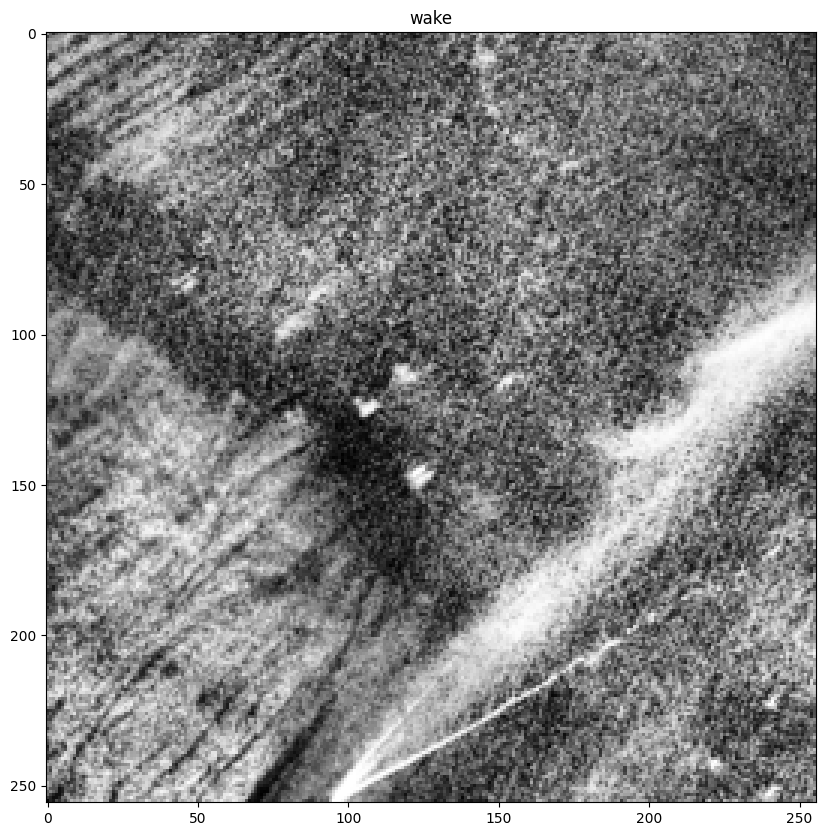

In [15]:
import torch
from torch import nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix
import numpy as np  

from pathlib import Path
import imageio.v2 as imageio
import tifffile
import torchvision.transforms as transforms
import matplotlib.pyplot as plt #

# Check if CUDA is available
if not torch.cuda.is_available():
    # Set device to CPU
    device = torch.device('cpu')
else:
    # Set device to GPU
    device = torch.device('cuda:0')

print(device)
resize_transform = transforms.Resize((256,256), antialias=True)
# Load the trained model weights
ckpt_path = 'epoch=19-step=140.ckpt'

# define the model:
class WakeClassifier(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False) # bias=False because bn is applied
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # Dropout
        self.drop = nn.Dropout(p=0.4)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with 2 classes

        # Other
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = BinaryAccuracy()
        self.test_accuracy = 0.0 # for hyperparameter optimization
        self.f1_score = BinaryF1Score()
        self.conf_matrix = BinaryConfusionMatrix()
        self.conf_matrix_pred = BinaryConfusionMatrix()
        
    def forward(self, x):
        # Convolutional layers with ReLU activation, batch normalization, and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop(self.fc2(x))
        return x
# Create instance of your model class (replace 'WakeClassifier' with your actual class name)
model = WakeClassifier().to(device)

# Load weights from checkpoint
# Ensure the map_location is set to 'cpu' to load the model on CPU
state_dict = torch.load(ckpt_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict["state_dict"])
model = model.eval()

IDX = 210

def read_img(idx):
    
    def correct_dim(img):
        # If the image is not already in grayscale, convert it
        if img.shape[2] == 3:  # Assuming the image is RGB
            img_gray = img[:,:,0]
        return img_gray
    
    b2 = [x for x in Path('xAIWakes/xAIWakes/B2').glob('**/*') if x.is_file()]
    b3 = [x for x in Path('xAIWakes/xAIWakes/B3').glob('**/*') if x.is_file()]
    b4 = [x for x in Path('xAIWakes/xAIWakes/B4').glob('**/*') if x.is_file()]
    b8 = [x for x in Path('xAIWakes/xAIWakes/B8').glob('**/*') if x.is_file()]
    b2_idx = b2[idx]
    b3_idx = [x for x in b3 if x.stem == b2_idx.stem][0]
    b4_idx = [x for x in b4 if x.stem == b2_idx.stem][0]
    b8_idx = [x for x in b8 if x.stem == b2_idx.stem][0]
    if b2_idx.name.endswith('png'):
        im_b2 = imageio.imread(b2_idx, pilmode='L')
        im_b3 = imageio.imread(b3_idx, pilmode='L')
        im_b4 = imageio.imread(b4_idx, pilmode='L')
        im_b8 = imageio.imread(b8_idx, pilmode='L')
    else:
        im_b2 = tifffile.imread(b2_idx)
        im_b3 = tifffile.imread(b3_idx)
        im_b4 = tifffile.imread(b4_idx)
        im_b8 = tifffile.imread(b8_idx)
        
        
    im_b2, im_b3, im_b4, im_b8 = correct_dim(im_b2), correct_dim(im_b3), correct_dim(im_b4), correct_dim(im_b8)
    im_stack = np.stack((im_b2, im_b3, im_b4, im_b8), axis=0)
    return im_stack.astype(np.float32)

def plot_output(input_tensor, out_log):
    im = input_tensor[0,0,:,:]
    plt.figure(figsize=(10,10))
    title = 'wake' if out_log else 'Clutter'
    plt.title(title)
    plt.imshow(im.numpy(), cmap='gray')
    plt.show()    

with torch.no_grad():
    input_data = read_img(idx=IDX)
    input_tensor = torch.from_numpy(input_data).to(device)
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = resize_transform(input_tensor)
    out = model(input_tensor)
    out_log = torch.argmax(out, dim=1)
    plot_output(input_tensor, out_log)
    